In [1]:
%matplotlib widget

from functools import partial

import pdb
import numpy as np
from scipy.signal import find_peaks
from scipy import optimize
import matplotlib.pyplot as plt

In [2]:
def heaviside(x, thresh):
    return np.array(x > thresh, dtype=float)

def sigmoid(x, thresh, steepness):
    return 1 / (1 + np.exp(-steepness * (x - thresh)))

def dxdt(x, w, inj_excite, tau, refrac=0.0):
    """Wilson-Cowan ODEs w/ a single activation function across all units."""
    return (-x + (1 - refrac * x) * sigmoid(x @ w + inj_excite, 0.5, 8)) / tau
    # return (-x + (1 - refrac * x) * heaviside(x @ w + inj_excite, 0.5)) / tau

def dxdt_v2(x, w, inj_excite, tau=20.0, tau_2=None, thresh=0.5, thresh_2=None,
            steepness=8.0, steepness_2=None):
    """Wilson-Cowan ODEs w/ distinct activation functions for two subgroups."""
    if tau_2 is None:
        tau_2 = tau
    if thresh_2 is None:
        thresh_2 = thresh
    if steepness_2 is None:
        steepness_2 = steepness
    
    inputs = (x @ w) + inj_excite
    n_dim = len(x)
    x_ = np.zeros((n_dim,))
    x_[:n_dim // 2] = (-x[:n_dim // 2] + sigmoid(inputs[:n_dim // 2], thresh,
                                                 steepness)) / tau
    x_[n_dim // 2:] = (-x[n_dim // 2:] + sigmoid(inputs[n_dim // 2:], thresh_2,
                                                 steepness_2)) / tau_2
    return x_

def jacobian(x, w, inj_excite, thresh, steepness):
    """Jacobian of Wilson-Cowan ODEs w/ a single activation function (dxdt)."""
    n_dim = len(x)
    x = np.array(x)  # convert to array if not one already
    g = (x @ w) + inj_excite
    J = np.zeros((n_dim, n_dim))
    for i_idx in range(n_dim):
        sig = sigmoid(g[i_idx], thresh, steepness)
        for j_idx in range(n_dim):
            # NB: scale by 2 if activation function is scaled by 2
            # dfdx = 2 * w[i_idx, j_idx] * steepness * (1 / sig - 1) * sig ** 2
            dfdx = w[i_idx, j_idx] * steepness * (1 / sig - 1) * sig ** 2
            if i_idx == j_idx:
                J[i_idx, j_idx] = -x[i_idx] + dfdx
            else:
                J[i_idx, j_idx] = dfdx
    return J

def rk4(t, x, dt, dxdt):
    
    # Calculate slopes
    k1 = dxdt(t, x)
    k2 = dxdt(t + (dt / 2.), x + (k1 / 2.))
    k3 = dxdt(t + (dt / 2.), x + (k2 / 2.))
    k4 = dxdt(t + dt, x + k3)
    
    # Calculate new x and y
    x_next = x + (dt / 6) * (k1 + (2 * k2) + (2 * k3) + k4)
    t_next = t + dt
    
    return t_next, x_next

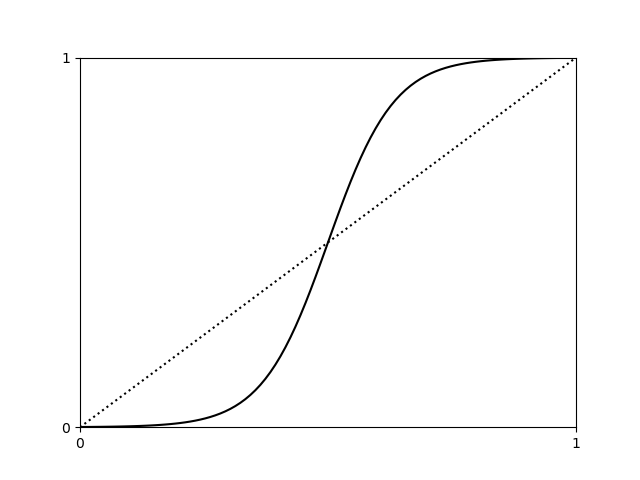

In [4]:
thresh = 0.5
steepness = 15
x = np.linspace(0, 1, 100)
y = sigmoid(x, thresh, steepness)
plt.figure()
plt.plot(x, y, 'k')
plt.plot([0, 1], [0, 1], color='k', ls=':')
# plt.vlines(thresh, 0, 1.0, color='k', ls=':')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.yticks([0, 1])
plt.xticks([0, 1])
plt.show()

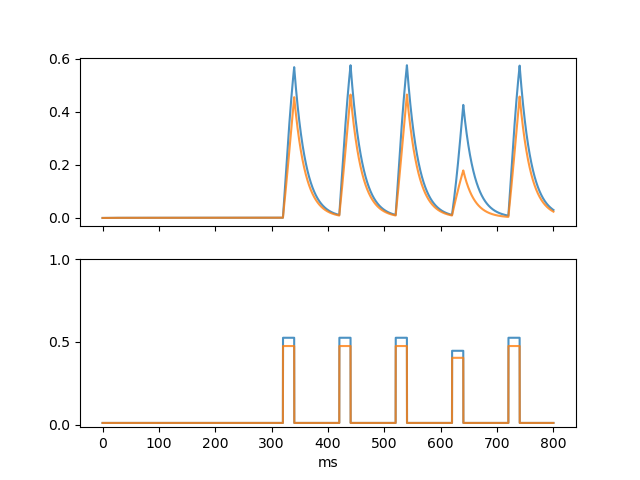

In [5]:
# tau = 28.
# w_ii = 0.032
# w_ij = -0.020

tau = 20.
w_ii = 0.5  # 1.0  # 0.9; 0.51  # 0.96
w_ij = -0.1  # -0.8  # -1.0; 0.49  # -0.6

dt = 0.01  # ms
tstop = 800  # ms
times = np.arange(0, tstop + dt, dt)
rep_interval = 100  # ms
x = np.zeros((len(times), 2))

# set initial state
x[0, :] = 0.0

# current injection: square wave at 20 ms
baseline = 0.01
inj_excite = np.zeros_like(x) + baseline
for rep_t in range(0, tstop, rep_interval):
    # square input
    t_inj = np.logical_and(times > rep_t + 20.0, times < rep_t + 40.0)
    inj_excite[t_inj, :] = baseline
    if rep_t > 200:
        inj_excite[t_inj, 0] = 0.525
        inj_excite[t_inj, 1] = 0.475

    # gaussian input
    # std = 5.0  # ms
    # latency = 20.0  # ms
    # event = np.exp(-0.5 * ((times - (rep_t + latency)) / std) ** 2)
    # if rep_t > 200:
    #     inj_excite[:, 0] = inj_excite[:, 0] + 0.55 * event
    #     inj_excite[:, 1] = inj_excite[:, 1] + 0.45 * event
    # else:
    #     inj_excite[:, 0] = inj_excite[:, 0] + 0.5 * event
    #     inj_excite[:, 1] = inj_excite[:, 1] + 0.5 * event

    # on final trial, reduce injected excitation (exogneous drive)
    if rep_t == tstop - 200:
        inj_excite[t_inj, :] *= 0.85

n_dim = x.shape[1]
# off-diagnal inhibitory weights
w = w_ij * (np.ones((n_dim, n_dim)) - np.eye(n_dim))
# diagnal excitatory weights
w += w_ii * np.eye(n_dim)

for t_idx, time in enumerate(times):
    if t_idx > 0:
        dx = dxdt(x[t_idx - 1, :], w, inj_excite[t_idx - 1, :], tau) * dt
        x[t_idx, :] = x[t_idx - 1, :] + dx

# plot
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(times, x, alpha=0.8)
# axes[0].set_yticks([0, 0.5, 1])
axes[1].plot(times, inj_excite, alpha=0.8)
axes[1].set_yticks([0, 0.5, 1])
axes[1].set_xlabel('ms')
plt.show()

In [6]:
# find fixed points
I = 0.01 * np.ones((2,))
def func_roots(x):
    x = np.array(x)  # convert to array if not one already
    return (dxdt(x, w, I, tau),
            jacobian(x, w, I, thresh=0.5, steepness=8))

# plot Jacobian over mulitple values of x_0 -> look for roots visually
# domain = np.linspace(0, 2, 100)
# J_0 = list()
# for x_0 in domain:
#     J_0.append(func_roots(x_0))
# plt.figure()
# plt.plot(domain, J_0)

# find roots numerically
sol = optimize.root(func_roots, x0=[0.5, 0.5], method='hybr', jac=True)
print(sol.x, sol.nfev, sol.message)

[0.00064467 0.00064467] 10 The solution converged.


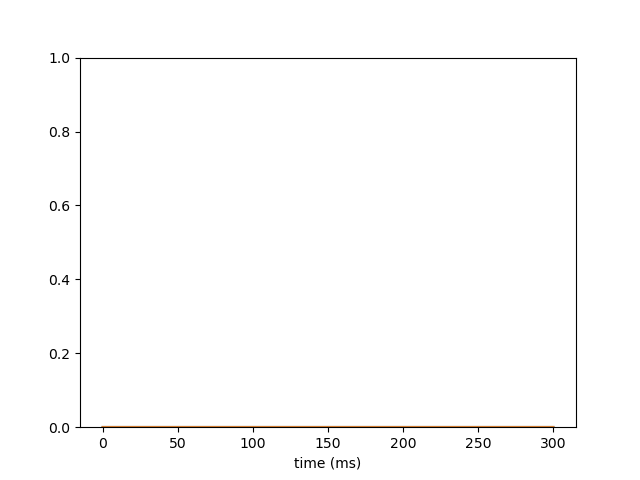

In [8]:
dt = 0.01  # ms
tstop = 300  # ms
times = np.arange(0, tstop + dt, dt)
x = np.zeros((len(times), 2))

# set initial state
x[0, :] = sol.x

# current injection: square wave at 20 ms
inj_excite = 0.01

for t_idx, time in enumerate(times):
    if t_idx > 0:
        dx = dxdt(x[t_idx - 1, :], w, inj_excite, tau) * dt
        x[t_idx, :] = x[t_idx - 1, :] + dx

# plot trajetory - it should flatline indicating the state is at a fixed point
fig, axes = plt.subplots(1, 1, sharex=True)
axes.plot(times, x, alpha=0.8)
axes.set_ylim([0, 1])
axes.set_xlabel('time (ms)')
plt.show()

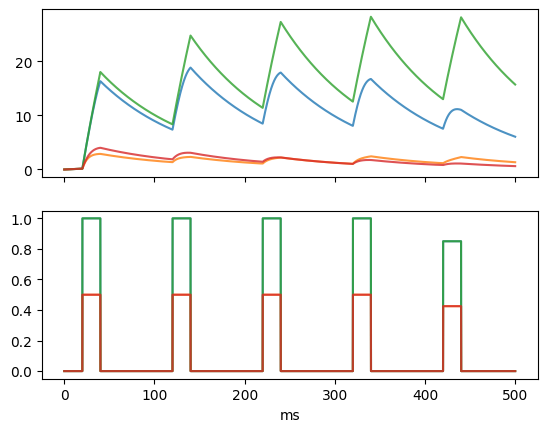

In [3]:
tau = 100.0
refrac = 0.0
w_ii = 0.0
w_ij = -0.015

dt = 0.01  # ms
tstop = 500  # ms
times = np.arange(0, tstop + dt, dt)
x = np.zeros((len(times), 4))

# set initial state
x[0, :] = 0.0

# current injection: square wave at 20 ms
baseline = 0.0
inj_excite = np.zeros_like(x) + baseline
for rep_t in range(0, tstop, 100):
    # square input
    t_inj = np.logical_and(times > rep_t + 20.0, times < rep_t + 40.0)
    inj_excite[t_inj, 0] = 1.0
    inj_excite[t_inj, 1] = 0.5
    inj_excite[t_inj, 2] = 1.0
    inj_excite[t_inj, 3] = 0.5

    # on final trial, reduce injected excitation (exogneous drive)
    if rep_t == tstop - 100:
        inj_excite[t_inj, :] *= 0.85

n_dim = x.shape[1]
# off-diagnal inhibitory weights
w = w_ij * (np.ones((n_dim, n_dim)) - np.eye(n_dim))
# diagnal excitatory weights
w += w_ii * np.eye(n_dim)

w = np.array([[w_ii, w_ij, 0, 0],
              [w_ij, w_ii, 0, 0],
              [w_ij*1.4, 0, w_ii, w_ij],
              [0, w_ij*1.4, w_ij, w_ii]])

for t_idx, time in enumerate(times):
    if t_idx > 0:
        dx = dxdt(x[t_idx - 1, :], w, inj_excite[t_idx - 1, :], tau) * dt
        x[t_idx, :] = x[t_idx - 1, :] + dx

# plot
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(times, x, alpha=0.8)
# axes[0].set_yticks([0, 0.5, 1])
axes[1].plot(times, inj_excite, alpha=0.8)
# axes[1].set_yticks([0, 0.5, 1])
axes[1].set_xlabel('ms')
plt.show()

In [4]:

def sim_dev(dev, w_ii, w_ij, w_ii_l2, w_ij_l2, w_fb, tau, tau_2,
            thresh, thresh_2, steepness, steepness_2):
    """Simulate competitive inhibitory network under deviant drive.

    Parameters
    ----------
    dev : float

    w_ii : float
        Recurrent connection weight for diagonal elements (ith -> ith unit)
        of the connectivity matrix. This value should be >=0 since this
        neural mass shouldn't inhibit itself.
    w_ij : float
        Recurrent connection weight for interacting off-diagonal elements
        (ith -> jth unit s.t. i != j) of the connectivity matrix. This value
        should be <=0 to provide competive inhbition.
    fb : float
        Feedback scaling factor for cross-laminar w_ij terms.

    Returns
    -------
    times : 
    x : 
    inj_excite : 
    w : 
    """

    # integration params
    dt = 0.1  # ms
    burn_in = 100 # ms
    tstop = 500  # ms; try 600 and fix below for one extra trial after dev
    times = np.arange(0, tstop + dt, dt)
    rep_interval = 100  # ms

    # network params
    # number of competing neural mass units per subgroup (i.e., representations
    # per layer)
    n_dim = 2
    # total units: multiply by two subgroups (e.g., layers)
    n_units = n_dim * 2
    x = np.zeros((len(times), n_units))

    # drive params
    baseline = 0.01
    # baseline = np.array([0.01, 0.01, 0.01, 0.01])
    inj_delta = 0.02 # difference in drive magnitude between representations

    # set initial state
    x[0, :] = 0.0

    # repetative injected excitation (exogenous drive): half-period of square
    # wave at 20 ms, lasting 20 ms
    inj_excite = np.zeros_like(x) + baseline
    # calculate decendng offset values for each representation (dimension) that
    # are inj_delta apart, zero-centered
    inj_offsets = np.linspace(inj_delta, 0, n_dim)
    inj_offsets -= inj_offsets.mean()
    for rep_t in range(burn_in, tstop, rep_interval):
        # square input
        t_inj = np.logical_and(times >= rep_t + 20.0, times < rep_t + 40.0)

        # injected excitation are 0.5 +/- offset for each representation
        for unit_idx in range(n_dim):
            inj_excite[t_inj, unit_idx::n_dim] = 0.5 + inj_offsets[unit_idx]

        # on final trial, reduce injected excitation (exogneous drive)
        # if rep_t == tstop - (2 * rep_interval):
        if rep_t == tstop - (rep_interval):
            inj_excite[t_inj, :] *= (1 + dev)

    # define network connectivity weight matrix
    # setup to accomodate a network of arbitrary # of representations
    # (dimensions), but should look something like this for n_dim=2:
    # w = np.array([[w_ii, w_ij, 0, 0],
    #               [w_ij, w_ii, 0, 0],
    #               [w_fb, w_fb / 2, w_ii_l2, w_ij_l2],
    #               [w_fb / 2, w_fb, w_ij_l2, w_ii_l2]])
    w = np.zeros((n_units, n_units))

    # 1st subgroup (layer)
    # diagnal excitatory weights
    w[:n_dim, :n_dim] += w_ii * np.eye(n_dim)
    # off-diagnal inhibitory weights
    w[:n_dim, :n_dim] += w_ij * (np.ones((n_dim, n_dim)) - np.eye(n_dim))

    # 2nd subgroup (layer)
    # diagnal excitatory weights
    w[n_dim:, n_dim:] += w_ii_l2 * np.eye(n_dim)
    # off-diagnal inhibitory weights
    w[n_dim:, n_dim:] += w_ij_l2 * (np.ones((n_dim, n_dim)) -
                                    np.eye(n_dim))
    
    # inhibition from 2nd subgroup -> 1st subgroup
    # diagnal ipsi-representation inhibitory weights
    w[n_dim:, :n_dim] += w_fb * np.eye(n_dim)
    # off-diagnal contra-representation inhibitory weights
    w[n_dim:, :n_dim] += (w_fb / 2) * (np.ones((n_dim, n_dim)) -
                                       np.eye(n_dim))
    
    def dxdt_v2_w_injection(t, x,
                            w=w, tau=tau, tau_2=tau_2, thresh=thresh,
                            thresh_2=thresh_2, steepness=steepness,
                            steepness_2=steepness_2, burn_in=burn_in,
                            rep_interval=rep_interval, tstop=tstop,
                            n_units=n_units, n_dim=n_dim,
                            inj_offsets=inj_offsets, baseline=baseline,
                            dev=dev):
        """Complete ODE system including time-dependent injected excitation.
        
        Note that this is needed to allow the RK4 method to evalute the system
        at times in-between time steps at which the injected current
        hasn't yet been explicitly defined.
        """
        # determine current 'stimulus' repetition onset time
        rep_tstart = burn_in + (np.abs(t - burn_in) // rep_interval) * rep_interval
        # if within the time bounds of afferent drive for the evoked response,
        # apply injected excitation that surpasses baseline drive
        inj_excite = np.zeros((n_units,))
        if t >= rep_tstart + 20.0 and t < rep_tstart + 40.0:
            for unit_idx in range(n_dim):
                inj_excite[unit_idx::n_dim] = 0.5 + inj_offsets[unit_idx]

            # on final trial, reduce injected excitation (exogneous drive)
            # if rep_tstart == tstop - (2 * rep_interval):
            if rep_tstart == tstop - (rep_interval):
                inj_excite *= (1 + dev)
        else:
            inj_excite = baseline

        return dxdt_v2(x, w, inj_excite,
                       tau=tau, tau_2=tau_2,
                       thresh=thresh, thresh_2=thresh_2,
                       steepness=steepness, steepness_2=steepness_2)

    # forward-Euler
    # for t_idx, time in enumerate(times):
    #     if t_idx > 0:
            # dx = dxdt_v2(x[t_idx - 1, :], w, inj_excite[t_idx - 1, :],
            #              tau=tau, tau_2=tau_2,
            #              thresh=thresh, thresh_2=thresh_2,
            #              steepness=steepness, steepness_2=steepness_2) * dt
            # x[t_idx, :] = x[t_idx - 1, :] + dx

    # Runge-Kutta (RK) 4
    # NB: be sure to use pre-computed time values as time calculated
    # recursively contains too much rounding error
    for t_idx, time in enumerate(times[:-1]):
        _time, x[t_idx + 1, :] = rk4(time, x[t_idx, :].copy(),
                                     dt, dxdt_v2_w_injection)

    return times, x, inj_excite, w

In [5]:
def plot_sim_dev(times, x, ax_1):
    colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:blue']
    # ax_1.plot(times, np.mean(x, axis=1), color=[0.2, 0.2, 0.2], alpha=1.0)
    # plot time course of unit spike rates
    for unit_idx in range(x.shape[1]):
        color = colors[unit_idx]
        ls = '-'
        if unit_idx >=2:
            ls = ':'
        x_traj = x[:, unit_idx]
        ax_1.plot(times, x_traj, color=color, ls=ls, alpha=1.0)
    # plot markers at avg event peaks
    x_avg = np.mean(x[:, :2], axis=1)
    peak_idxs, _ = find_peaks(x_avg)
    ax_1.scatter(times[peak_idxs], x_avg[peak_idxs], marker='_', color='k')
    # er_avg = list()
    # for peak_idx in peak_idxs:
    #     peak_time = times[peak_idx]
    #     er_win = np.logical_and(times > peak_time - 40, times < peak_time + 60)
    #     er_avg.append(np.mean(x[er_win, :]))
    # ax_1.scatter(times[peak_idxs], er_avg, marker='_', color='grey')

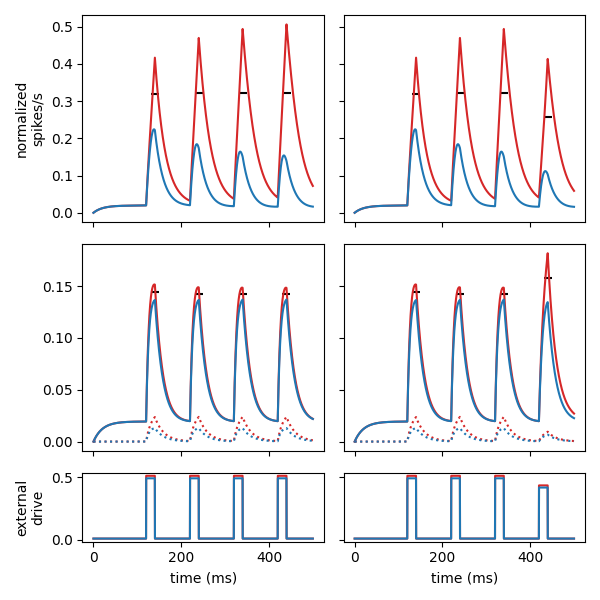

In [6]:
# I = 0.51, 0.49; baseline = 0.01; 1 * sigmoid
# NB: this only produces an increasing deviant evoked response for neg deviants

dev = -0.15  # change in proportion of original injected excitation

w_ii = 0.9
w_ij = -0.9
w_ii_l2 = 0.3
w_ij_l2 = -3.0
w_fb = -8.0  # -5.0 for tau/2

tau = 20
tau_2 = 20
thresh = 0.5
thresh_2 = 0.7
steepness = 8
steepness_2 = 15

# setup figure
gridspec = {'width_ratios': [1, 1], 'height_ratios': [3, 3, 1]}
fig, axes = plt.subplots(3, 2, sharex='col', sharey='row',
                         gridspec_kw=gridspec, figsize=(6, 6))

# without DEV; without L6
times, x, inj_excite, _w = sim_dev(dev=0.0,
                                   w_ii=w_ii,
                                   w_ij=w_ij,
                                   w_ii_l2=w_ii_l2,
                                   w_ij_l2=w_ij_l2,
                                   w_fb=0,
                                   tau=tau,
                                   tau_2=tau_2,
                                   thresh=thresh,
                                   thresh_2=thresh_2,
                                   steepness=steepness,
                                   steepness_2=steepness_2)
plot_sim_dev(times, x[:, :2], axes[0, 0])  # only plot first subgroup

# with DEV; without L6
times, x, inj_excite, _w = sim_dev(dev=dev,
                                   w_ii=w_ii,
                                   w_ij=w_ij,
                                   w_ii_l2=w_ii_l2,
                                   w_ij_l2=w_ij_l2,
                                   w_fb=0,
                                   tau=tau,
                                   tau_2=tau_2,
                                   thresh=thresh,
                                   thresh_2=thresh_2,
                                   steepness=steepness,
                                   steepness_2=steepness_2)
plot_sim_dev(times, x[:, :2], axes[0, 1])  # only plot first subgroup

# without DEV; with L6
times, x, inj_excite, _w = sim_dev(dev=0.0,
                                   w_ii=w_ii,
                                   w_ij=w_ij,
                                   w_ii_l2=w_ii_l2,
                                   w_ij_l2=w_ij_l2,
                                   w_fb=w_fb,
                                   tau=tau,
                                   tau_2=tau_2,
                                   thresh=thresh,
                                   thresh_2=thresh_2,
                                   steepness=steepness,
                                   steepness_2=steepness_2)
plot_sim_dev(times, x, axes[1, 0])  # now plot both subgroups
# plot time course for injected excitation
colors = ['tab:red', 'tab:blue']
for unit_idx in range(inj_excite.shape[1] // 2):
    inj_excite_traj = inj_excite[:, unit_idx]
    axes[2, 0].plot(times, inj_excite_traj, color=colors[unit_idx], alpha=1.0)
    # # ax_2.set_ylim([0, 1])
    # ax_2.set_yticks([0, 0.5])

# with DEV; with L6
times, x, inj_excite, _w = sim_dev(dev=dev,
                                   w_ii=w_ii,
                                   w_ij=w_ij,
                                   w_ii_l2=w_ii_l2,
                                   w_ij_l2=w_ij_l2,
                                   w_fb=w_fb,
                                   tau=tau,
                                   tau_2=tau_2,
                                   thresh=thresh,
                                   thresh_2=thresh_2,
                                   steepness=steepness,
                                   steepness_2=steepness_2)
plot_sim_dev(times, x, axes[1, 1])  # now plot both subgroups
# plot time course for injected excitation
for unit_idx in range(inj_excite.shape[1] // 2):
    inj_excite_traj = inj_excite[:, unit_idx]
    axes[2, 1].plot(times, inj_excite_traj, color=colors[unit_idx], alpha=1.0)
    # ax_2.set_ylim([0, 1])
    # ax_2.set_yticks([0, 0.5])

axes[0, 0].set_ylabel('normalized\nspikes/s')
axes[2, 0].set_ylabel('external\ndrive')
axes[2, 0].set_xlabel('time (ms)')
axes[2, 1].set_xlabel('time (ms)')
fig.tight_layout()
plt.show()

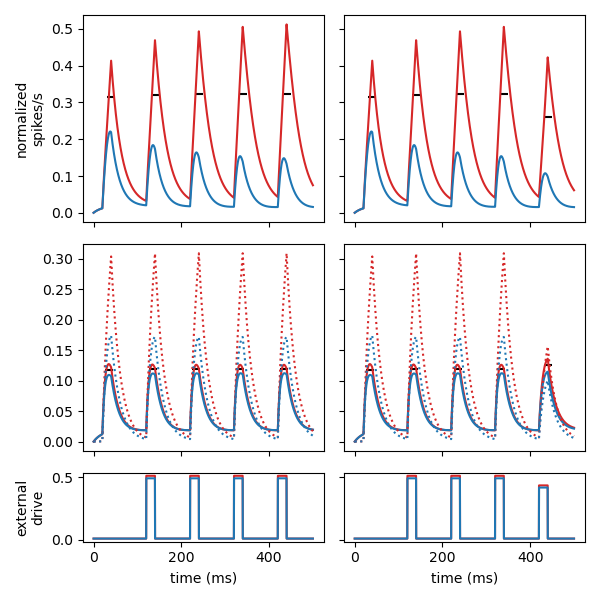

In [69]:
# I = 0.51, 0.49; baseline = 0.01; 1 * sigmoid
# NB: this one is subtle, but works for both pos and neg deviants!

dev = -0.15  # change in proportion of original injected excitation

w_ii = 0.9
w_ij = -0.9
w_ii_l2 = 0.2
w_ij_l2 = -0.4
w_fb = -0.8  # -5.0 for tau/2

tau = 20
tau_2 = 20
thresh = 0.5
thresh_2 = 0.5
steepness = 8
steepness_2 = 15

# setup figure
gridspec = {'width_ratios': [1, 1], 'height_ratios': [3, 3, 1]}
fig, axes = plt.subplots(3, 2, sharex='col', sharey='row',
                         gridspec_kw=gridspec, figsize=(6, 6))

# without DEV; without L6
times, x, inj_excite, _ = sim_dev(dev=0.0,
                                  w_ii=w_ii,
                                  w_ij=w_ij,
                                  w_ii_l2=w_ii_l2,
                                  w_ij_l2=w_ij_l2,
                                  w_fb=0,
                                  tau=tau,
                                  tau_2=tau_2,
                                  thresh=thresh,
                                  thresh_2=thresh_2,
                                  steepness=steepness,
                                  steepness_2=steepness_2)
plot_sim_dev(times, x[:, :2], axes[0, 0])  # only plot first subgroup

# with DEV; without L6
times, x, inj_excite, _ = sim_dev(dev=dev,
                                  w_ii=w_ii,
                                  w_ij=w_ij,
                                  w_ii_l2=w_ii_l2,
                                  w_ij_l2=w_ij_l2,
                                  w_fb=0,
                                  tau=tau,
                                  tau_2=tau_2,
                                  thresh=thresh,
                                  thresh_2=thresh_2,
                                  steepness=steepness,
                                  steepness_2=steepness_2)
plot_sim_dev(times, x[:, :2], axes[0, 1])  # only plot first subgroup

# without DEV; with L6
times, x, inj_excite, _ = sim_dev(dev=0.0,
                                  w_ii=w_ii,
                                  w_ij=w_ij,
                                  w_ii_l2=w_ii_l2,
                                  w_ij_l2=w_ij_l2,
                                  w_fb=w_fb,
                                  tau=tau,
                                  tau_2=tau_2,
                                  thresh=thresh,
                                  thresh_2=thresh_2,
                                  steepness=steepness,
                                  steepness_2=steepness_2)
plot_sim_dev(times, x, axes[1, 0])  # now plot both subgroups
# plot time course for injected excitation
colors = ['tab:red', 'tab:blue']
for unit_idx in range(inj_excite.shape[1] // 2):
    inj_excite_traj = inj_excite[:, unit_idx]
    axes[2, 0].plot(times, inj_excite_traj, color=colors[unit_idx], alpha=1.0)
    # # ax_2.set_ylim([0, 1])
    # ax_2.set_yticks([0, 0.5])

# with DEV; with L6
times, x, inj_excite, w = sim_dev(dev=dev,
                                  w_ii=w_ii,
                                  w_ij=w_ij,
                                  w_ii_l2=w_ii_l2,
                                  w_ij_l2=w_ij_l2,
                                  w_fb=w_fb,
                                  tau=tau,
                                  tau_2=tau_2,
                                  thresh=thresh,
                                  thresh_2=thresh_2,
                                  steepness=steepness,
                                  steepness_2=steepness_2)
plot_sim_dev(times, x, axes[1, 1])  # now plot both subgroups
# plot time course for injected excitation
for unit_idx in range(inj_excite.shape[1] // 2):
    inj_excite_traj = inj_excite[:, unit_idx]
    axes[2, 1].plot(times, inj_excite_traj, color=colors[unit_idx], alpha=1.0)
    # ax_2.set_ylim([0, 1])
    # ax_2.set_yticks([0, 0.5])

axes[0, 0].set_ylabel('normalized\nspikes/s')
axes[2, 0].set_ylabel('external\ndrive')
axes[2, 0].set_xlabel('time (ms)')
axes[2, 1].set_xlabel('time (ms)')
fig.tight_layout()
plt.show()

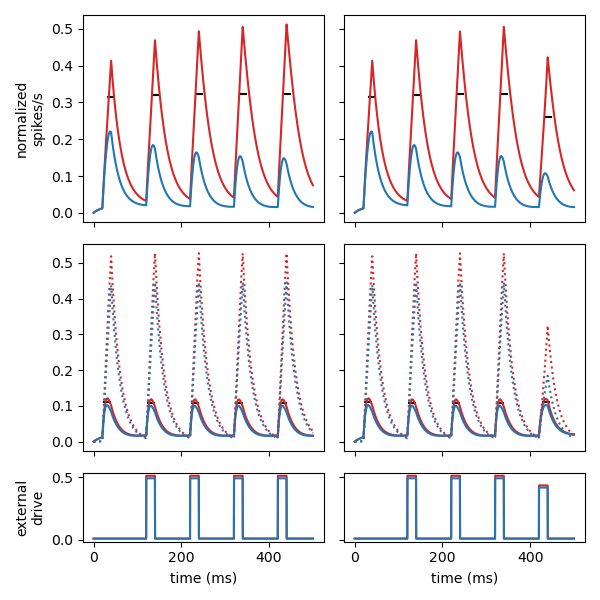

In [70]:
# I = 0.51, 0.49; baseline = 0.01; 1 * sigmoid
# NB: this one is experimental - doesn't work yet

dev = -0.15  # change in proportion of original injected excitation

w_ii = 0.9
w_ij = -0.9
w_ii_l2 = 0.5
w_ij_l2 = -0.2
w_fb = -0.6  # -5.0 for tau/2

tau = 20
tau_2 = 20
thresh = 0.5
thresh_2 = 0.5
steepness = 8
steepness_2 = 15

# setup figure
gridspec = {'width_ratios': [1, 1], 'height_ratios': [3, 3, 1]}
fig, axes = plt.subplots(3, 2, sharex='col', sharey='row',
                         gridspec_kw=gridspec, figsize=(6, 6))

# without DEV; without L6
times, x, inj_excite, _ = sim_dev(dev=0.0,
                                  w_ii=w_ii,
                                  w_ij=w_ij,
                                  w_ii_l2=w_ii_l2,
                                  w_ij_l2=w_ij_l2,
                                  w_fb=0,
                                  tau=tau,
                                  tau_2=tau_2,
                                  thresh=thresh,
                                  thresh_2=thresh_2,
                                  steepness=steepness,
                                  steepness_2=steepness_2)
plot_sim_dev(times, x[:, :2], axes[0, 0])  # only plot first subgroup

# with DEV; without L6
times, x, inj_excite, _ = sim_dev(dev=dev,
                                  w_ii=w_ii,
                                  w_ij=w_ij,
                                  w_ii_l2=w_ii_l2,
                                  w_ij_l2=w_ij_l2,
                                  w_fb=0,
                                  tau=tau,
                                  tau_2=tau_2,
                                  thresh=thresh,
                                  thresh_2=thresh_2,
                                  steepness=steepness,
                                  steepness_2=steepness_2)
plot_sim_dev(times, x[:, :2], axes[0, 1])  # only plot first subgroup

# without DEV; with L6
times, x, inj_excite, _ = sim_dev(dev=0.0,
                                  w_ii=w_ii,
                                  w_ij=w_ij,
                                  w_ii_l2=w_ii_l2,
                                  w_ij_l2=w_ij_l2,
                                  w_fb=w_fb,
                                  tau=tau,
                                  tau_2=tau_2,
                                  thresh=thresh,
                                  thresh_2=thresh_2,
                                  steepness=steepness,
                                  steepness_2=steepness_2)
plot_sim_dev(times, x, axes[1, 0])  # now plot both subgroups
# plot time course for injected excitation
colors = ['tab:red', 'tab:blue']
for unit_idx in range(inj_excite.shape[1] // 2):
    inj_excite_traj = inj_excite[:, unit_idx]
    axes[2, 0].plot(times, inj_excite_traj, color=colors[unit_idx], alpha=1.0)
    # # ax_2.set_ylim([0, 1])
    # ax_2.set_yticks([0, 0.5])

# with DEV; with L6
times, x, inj_excite, w = sim_dev(dev=dev,
                                  w_ii=w_ii,
                                  w_ij=w_ij,
                                  w_ii_l2=w_ii_l2,
                                  w_ij_l2=w_ij_l2,
                                  w_fb=w_fb,
                                  tau=tau,
                                  tau_2=tau_2,
                                  thresh=thresh,
                                  thresh_2=thresh_2,
                                  steepness=steepness,
                                  steepness_2=steepness_2)
plot_sim_dev(times, x, axes[1, 1])  # now plot both subgroups
# plot time course for injected excitation
for unit_idx in range(inj_excite.shape[1] // 2):
    inj_excite_traj = inj_excite[:, unit_idx]
    axes[2, 1].plot(times, inj_excite_traj, color=colors[unit_idx], alpha=1.0)
    # ax_2.set_ylim([0, 1])
    # ax_2.set_yticks([0, 0.5])

axes[0, 0].set_ylabel('normalized\nspikes/s')
axes[2, 0].set_ylabel('external\ndrive')
axes[2, 0].set_xlabel('time (ms)')
axes[2, 1].set_xlabel('time (ms)')
fig.tight_layout()
plt.show()

In [14]:
dev_win = np.logical_and(times > 400 - 40, times < 500)
prior_baseline_win = np.logical_and(times > 300 - 40, times < 400)
x_fb_diff = x[dev_win, 2:] - x[prior_baseline_win, 2:]
print(np.mean(x_fb_diff))

-0.010850345730316261


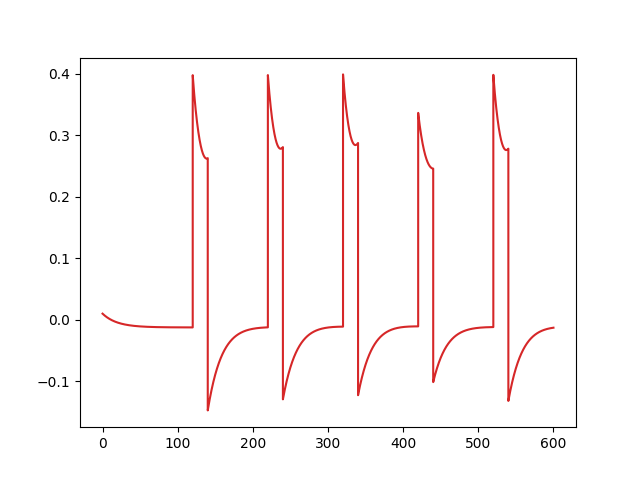

In [176]:
inhib = x @ (w * (np.ones_like(w) - np.eye(w.shape[0]))) + inj_excite
plt.figure()
plt.plot(times, inhib[:, 0], color='tab:red')
# plt.plot(times, inhib[:, 1], color='tab:blue')
#plt.plot(times, inhib[:, :2].mean(axis=1), color='k')
plt.show()

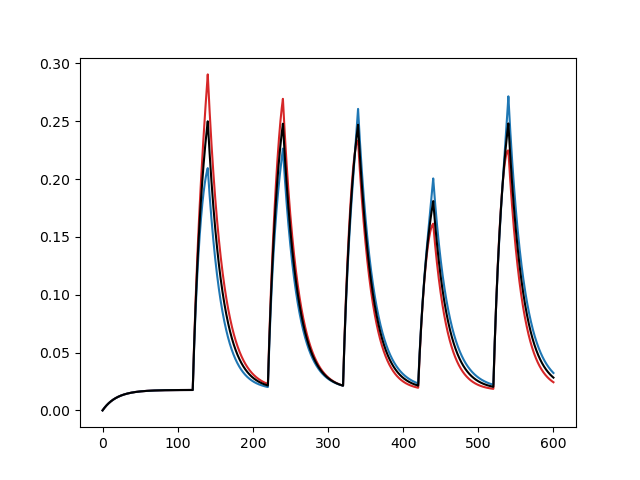

In [9]:
excite = x @ (w * np.eye(w.shape[0]))
plt.figure()
plt.plot(times, excite[:, 0], color='tab:red')
plt.plot(times, excite[:, 1], color='tab:blue')
plt.plot(times, excite[:, :2].mean(axis=1), color='k')
plt.show()

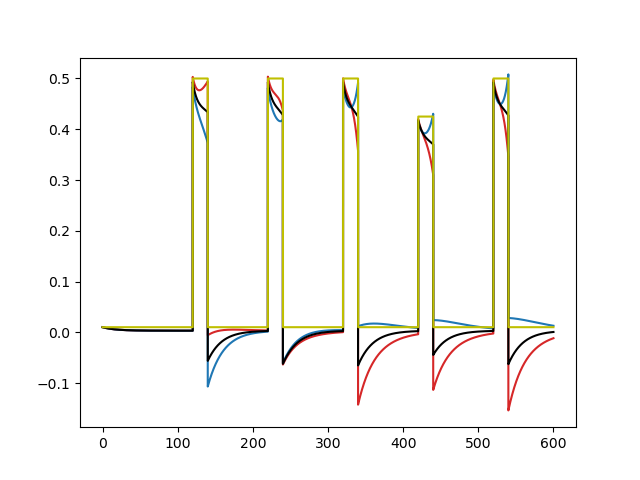

In [10]:
tot_excit = x@w + inj_excite
plt.figure()
plt.plot(times, tot_excit[:, 0], color='tab:red')
plt.plot(times, tot_excit[:, 1], color='tab:blue')
plt.plot(times, tot_excit[:, :2].mean(axis=1), color='k')
plt.plot(times, inj_excite.mean(axis=1), color='y')
plt.show()

In [265]:
plt.close('all')

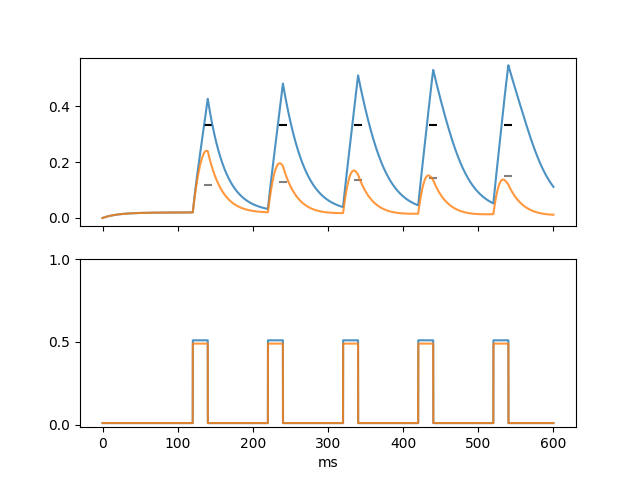

In [10]:
tau = 20.
w_ii = 0.96  # 0.9; 0.51  # 0.96
w_ij = -0.92  # -1.0; 0.49  # -0.6

dt = 0.01  # ms
burn_in = 100 # ms
tstop = 600  # ms
times = np.arange(0, tstop + dt, dt)
rep_interval = 100  # ms
x = np.zeros((len(times), 2))

# set initial state
x[0, :] = 0.0

# current injection: square wave at 20 ms
baseline = 0.01
inj_excite = np.zeros_like(x) + baseline
for rep_t in np.arange(burn_in, tstop, rep_interval):
    # square input
    t_inj = np.logical_and(times > rep_t + 20.0, times < rep_t + 40.0)
    inj_excite[t_inj, 0] = 0.51
    inj_excite[t_inj, 1] = 0.49

    # on 2nd to last trial, reduce injected excitation (exogneous drive)
    # if rep_t == tstop - 200:
    #     inj_excite[t_inj, :] *= 0.85

n_dim = x.shape[1]
# off-diagnal inhibitory weights
w = w_ij * (np.ones((n_dim, n_dim)) - np.eye(n_dim))
# diagnal excitatory weights
w += w_ii * np.eye(n_dim)

for t_idx, time in enumerate(times):
    if t_idx > 0:
        dx = dxdt(x[t_idx - 1, :], w, inj_excite[t_idx - 1, :], tau) * dt
        x[t_idx, :] = x[t_idx - 1, :] + dx

# plot
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(times, x, alpha=0.8)
# plot markers at avg event peaks
x_avg = np.mean(x, axis=1)
peak_idxs, _ = find_peaks(x_avg)
axes[0].scatter(times[peak_idxs], x_avg[peak_idxs], marker='_', color='k')
er_avg = list()
for rep_t in range(burn_in, tstop, rep_interval):
    er_win = np.logical_and(times > rep_t, times < rep_t + rep_interval)
    er_avg.append(np.mean(x[er_win, :]))
axes[0].scatter(times[peak_idxs], er_avg, marker='_', color='grey')

# axes[0].set_yticks([0, 0.5, 1])
axes[1].plot(times, inj_excite, alpha=0.8)
axes[1].set_yticks([0, 0.5, 1])
axes[1].set_xlabel('ms')
plt.show()